# Introductory practical guide to Statistics in Python

While doing research, you have, and will spend a considerable amount of time designing your experiments, executing them, and gathering data. You will then need to draw conclusions - have my experiments found something *significant*? As with everything in science, there is a particular rigour expected in data analysis, which ensures that the conclusions are made based on mathematics, probablity, and the chance of your results seeming different by chance - and not demonstrating a real effect. Simply, if you want to claim something, you will often need to determine whether an action you have taken (for example, using an antibiotic, using different reaction conditions, etc.) had a real effect on the outcome of an experiment.

This course will help you build a foundation in statistical analysis using Python, which you can then use in your chemistry (and other) research. You’ll start with two-group comparisons, learning how to use t-tests and non-parametric methods to analyze differences between groups. Next, you’ll explore ANOVA for comparing multiple groups and understanding variability, and finally, tackle multiple hypothesis testing to manage more complex datasets.

This course is not intended to teach you all code-related concepts used in this notebook. For example, we will use the pandas library so we can use dataframes (a way of storing data), which are uniquely suitable for storing data for statistical analysis. Beyond a practical application, will not look into data processing, manipulation or how they work. If you are interested in that, there is a multitude of online resources you can use to learn more.

## Intended learning outcomes
By the end of this course, you will be able to:

* Understand the need for statistical analysis of data 
* Do exploratory data analysis in preparation for statistical analysis
* Conduct statistical tests on simple datasets, including t-tests and ANOVA
* Apply multiple hypothesis testing to control error rates in more complex datasets
* Become confident to explore other statistical methods suited for your unique research needs

# Part 1 - two-group comparisons

### Hypothesis Testing and p-value

Hypothesis testing is a fundamental statistical method used to determine whether there is enough evidence in a sample of data to determine that a certain condition is true for the entire population (for example, if you would measure all the penguins, or do an unlimited number of replicate experiments). In the context of comparing two group means, we typically set up two hypotheses:

* Null Hypothesis (H₀): There is no significant difference between the distribution of the two groups.
* Alternative Hypothesis (H₁): There is a significant difference between the distribution of the two groups.

By doing hypothesis testing, we are trying to show that the null hypothesis is false, which by logic would mean that the alternative hypothesis is true. 

To test this, we usually calculate a p-value, which represents the probability of obtaining results at least as extreme (different from each other) as the observed data, assuming that the null hypothesis is true.

A small p-value (typically less than 0.05, but in medical research, it is often set to 0.01 or even 0.001.) suggests that obtaining such results is not very probable (it would happen with probability equal to the p-value) under the null hypothesis, leading us to reject H₀ and conclude that there is a significant difference between the groups.

A p-value greater than 0.05 suggests insufficient evidence to reject H₀.
It is important to remember though that rejecting H₀ *does not prove* that there is no significant difference.
This is not what we have been testing for.
There is simply not enough evidence to say that there is significant difference - inferring other conclusions is inappropriate.

### Practical application

In this part, we will learn how to compare the means (or distributions) of two groups using statistical tests, specifically focusing on the Palmer Penguins dataset.

We will compare the body mass (*dependent variable*) between two penguin species (*independent variable*) to determine if there is a significant difference.

The steps include:

* Data loading and exploratory data analysis (EDA)
* Visualization techniques for comparing two groups
* Checking assumptions for statistical tests
* Statistical tests: Mann-Whitney U test and Independent t-test
* Interpreting results

## Loading necessary libraries and data

The script below is written for you and ready to execute, to facilitate fast transition to the statistical analysis.

In [17]:
# First, we need to install all necessary packages - this script checks what is installed, and installs the missing ones.
import importlib
import subprocess
import sys

# List of required packages
required_packages = [
    'pandas', 
    'numpy', 
    'matplotlib', 
    'seaborn', 
    'scipy'
]

# Function to check if a package is installed
def check_install_package(package):
    try:
        importlib.import_module(package)
        print(f"{package} is already installed.")
    except ImportError:
        print(f"{package} is not installed. Installing...")
        subprocess.check_call([sys.executable, '-m', 'pip', 'install', package])

# Check and install each package
for package in required_packages:
    check_install_package(package)

pandas is already installed.
numpy is already installed.
matplotlib is already installed.
seaborn is already installed.
scipy is already installed.


In [18]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind, mannwhitneyu, shapiro, levene

# Load Palmer Penguins dataset
from seaborn import load_dataset

# Load the dataset
penguins = load_dataset('penguins')

# Display the first few rows of the dataset
penguins.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,Male
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,Female
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,Female
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,Female


## Data loading and cleaning

In our dataset, we have some missing data - we will drop the rows that contain no values, and select the two out of three species that we are interested in comparing.

In [19]:
# Drop rows with missing values for simplicity
penguins_clean = penguins.dropna()

# Select two species for comparison: Adelie and Gentoo
penguins_two_species = penguins_clean[penguins_clean['species'].isin(['Adelie', 'Gentoo'])]

# Display the first few rows of the cleaned dataset
penguins_two_species.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,Male
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,Female
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,Female
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,Female
5,Adelie,Torgersen,39.3,20.6,190.0,3650.0,Male


## Exploratory data analysis

We will now look at the gathered data - so we know what we are analysing.
The first step is to look at the summary statistics for both the species.



In [20]:
# Summary statistics by species
summary_stats = penguins_two_species.groupby('species')['body_mass_g'].describe()
summary_stats

,count,mean,std,min,25%,50%,75%,max
species,,,,,,,,
Adelie,146.0,3706.164384,458.620135,2850.0,3362.5,3700.0,4000.0,4775.0
Gentoo,119.0,5092.436975,501.476154,3950.0,4700.0,5050.0,5500.0,6300.0


In the table above, we see the number of datapoints per species, the mean value (it looks different, but is it?), the standard deviation, minimum and maximum values, and the 1st, 2nd and 3rd quartile values.
While these look different, we cannot say anything about the significance of the difference yet.

Before attempting analysis, let's visualise the data first using box plots and histograms

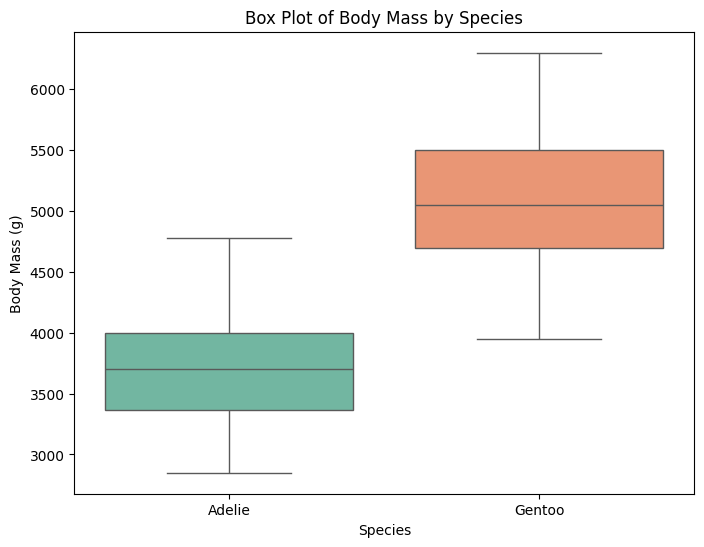

In [21]:
# Box plot for visual comparison
plt.figure(figsize=(8, 6))
sns.boxplot(x='species', y='body_mass_g', data=penguins_two_species, hue='species', palette='Set2', legend=False)
plt.title('Box Plot of Body Mass by Species')
plt.xlabel('Species')
plt.ylabel('Body Mass (g)')
plt.show()

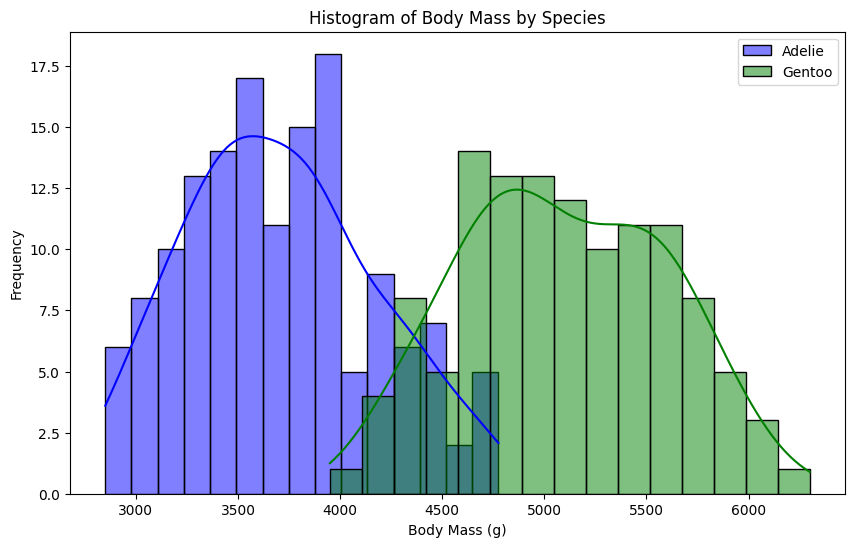

In [22]:
# Histograms for data distribution
plt.figure(figsize=(10, 6))
sns.histplot(penguins_two_species[penguins_two_species['species'] == 'Adelie']['body_mass_g'], bins=15, kde=True, color='blue', label='Adelie')
sns.histplot(penguins_two_species[penguins_two_species['species'] == 'Gentoo']['body_mass_g'], bins=15, kde=True, color='green', label='Gentoo')
plt.title('Histogram of Body Mass by Species')
plt.xlabel('Body Mass (g)')
plt.ylabel('Frequency')
plt.legend()
plt.show()

From the plots above, we can see that the two body mass distributions *look* different. Regardless of how different they look, a visual proof is not enough. We need to now perform formal statistical analysis on the data.

### Two group comparisons - data assumptions

For two-group comparisons you would usually use a t-test, which tests the null hypotesis in respect to the means of the distributions. It comes in several variations (for example, for paired and unpaired data).
Note: Paired data is for example a score a particular person got on a test before and after reading a coursebook. Unpaired data is any other data where a link between the values in the two datasets is not apparent.

You can only use the t-test if some assumptions about your data are met, or it will produce invalid results:

1.	Independence of Observations: The data points in each group must be independent of each other.
2.	Normality: The data in each group should be approximately normally distributed, which is especially important for small sample sizes. This can be checked using normality tests (e.g., Shapiro-Wilk test) or visually with Q-Q plots.
3.	Homogeneity of Variances: The variances in the two groups should be roughly equal. This can be assessed using tests such as Levene’s test.

If assumptions 2 or 3 are not met, you should use a non-parametric test, such as Mann-Whitney U test. This test does not compare means, rather than that comparing the median and the shape of the distribution.

If assumption 1 is not met, you should use a pairwise t-test or Wilcoxon rank-sum test (see section "Other Special Cases")

When these assumptions are met, the t-test is preferred over non-parametric alternatives like the Mann-Whitney U test because it is more statistically powerful. This means that the t-test is more likely to detect a true difference between the group means, given the same sample size. The Mann-Whitney U test does not assume normality and is less affected by outliers, but it typically has less power than the t-test when data are normally distributed and variances are equal. Therefore, when the assumptions of the t-test are met, it provides a more efficient and reliable way to detect differences between groups.

### Checking assumptions

We use the Shapiro-Wilk test to check if the body mass data is normally distributed for each species.


In [ ]:
# Shapiro-Wilk test for normality
shapiro_adelie = shapiro(penguins_two_species[penguins_two_species['species'] == 'Adelie']['body_mass_g'])
shapiro_gentoo = shapiro(penguins_two_species[penguins_two_species['species'] == 'Gentoo']['body_mass_g'])

print(f"Shapiro-Wilk Test for Adelie: p-value = {shapiro_adelie.pvalue:.4f}")
print(f"Shapiro-Wilk Test for Gentoo: p-value = {shapiro_gentoo.pvalue:.4f}")

We use Levene’s test to check if the variances are equal between the two groups.

In [ ]:
# Levene's test for equal variances
levene_test = levene(penguins_two_species[penguins_two_species['species'] == 'Adelie']['body_mass_g'],
                     penguins_two_species[penguins_two_species['species'] == 'Gentoo']['body_mass_g'])

print(f"Levene's Test for Equal Variances: p-value = {levene_test.pvalue:.4f}")

### Outcome of the assumption testing

As the body mass data for the Gentoo species is not normally distributed, and the variances are not equal for both species, we cannot use the t-test to determine whether the mean body mass between the two species is significantly different. We will therefore use the the Mann-Whitney U test.

### Testing the difference in the means using the Mann-Whitney U test


In [ ]:
# Mann-Whitney U test
u_stat, u_pval = mannwhitneyu(penguins_two_species[penguins_two_species['species'] == 'Adelie']['body_mass_g'],
                              penguins_two_species[penguins_two_species['species'] == 'Gentoo']['body_mass_g'])

print(f"Mann-Whitney U Test: U-statistic = {u_stat:.6f}, p-value = {u_pval:.6f}")

### Interpreting results

Coming back to the theory bit, in the context of comparing two group means, we set up two hypotheses:

* Null Hypothesis (H₀): There is no significant difference between the means of the two groups.
* Alternative Hypothesis (H₁): There is a significant difference between the means of the two groups.

The p-value from the Mann-Whitney U test helps determine if there is a significant difference between the means of the two species.

* If p < 0.05, we reject the null hypothesis and conclude that there is a significant difference between the groups.
* If p ≥ 0.05, we fail to reject the null hypothesis and conclude that there is no evidence for significant difference between the groups (which again, does not equal to evidence of no difference!)

We can see that the p-value is less than 0.05, so we reject the null hypothesis and can now conclude: The Adelie and Gentoo species have significantly different mean body mass.

### What to do if my data does fulfill the t-test assumptions?

While the example data is not normally distributed, and the variances in data are not equal between the two species, your dataset might contain normally distributed data with equal variances.
In that case, you can perform a t-test using the following, or similar code, with the interpretation of the data same as for the Mann-Whitney U test.

    #Independent t-test
    t_stat, t_pval = ttest_ind(penguins_two_species[penguins_two_species['species'] == 'Adelie']['body_mass_g'],
                               penguins_two_species[penguins_two_species['species'] == 'Gentoo']['body_mass_g'])

    print(f"Independent T-Test: t-statistic = {t_stat:.6f}, p-value = {t_pval:.6f}")

### Other special cases

The above is a very basic approach. Your data might require a slightly deeper analysis.
For example, let's say that you are researching the effect of students wathching a video on their test results, or the effect of a growth hormone treatment on the body mass of mice.
In these cases, you would compare the test result or body mass before and after treatment, with the two groups of data not being independent from each other. You should even know which values in each dataset correspond to the same individuals.

With data like that, you should explore doing a pairwise t-test - provided that your data is normally distributed and of equal variance, or Wilcoxon signed-rank test if not.

One thing you might have noticed is that the body mass histograms generated in the Exploratory Data Analysis for both species look like thay might each have two peaks - two local maxima, which could suggest that these distributions are bimodal - or comprised of two (or more) sub-distributions.

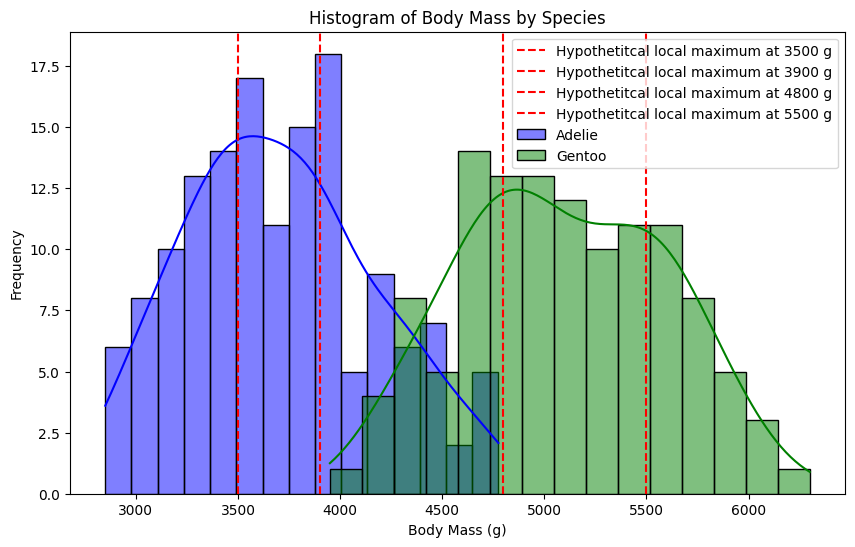

In [30]:
# Histograms for data distribution with vertical lines
plt.figure(figsize=(10, 6))

# Histogram for Adelie species
sns.histplot(
    penguins_two_species[penguins_two_species['species'] == 'Adelie']['body_mass_g'], 
    bins=15, kde=True, color='blue', label='Adelie'
)

# Histogram for Gentoo species
sns.histplot(
    penguins_two_species[penguins_two_species['species'] == 'Gentoo']['body_mass_g'], 
    bins=15, kde=True, color='green', label='Gentoo'
)

# Add vertical red lines at specified positions
for line in [3500, 3900, 4800, 5500]:
    plt.axvline(x=line, color='red', linestyle='--', label=f'Hypothetitcal local maximum at {line} g')

# Title and labels
plt.title('Histogram of Body Mass by Species')
plt.xlabel('Body Mass (g)')
plt.ylabel('Frequency')

# Combine labels for vertical lines to avoid repetition in legend
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

# Show the plot
plt.show()

Here, it might be that the males and females within species have distinct body mass distributions.

It is possible to analyse differences between groups based on more than one independent variable: here, we could test variables of *body mass* and *sex*; and elucidate which of these variables has a significant effect.
It is also possible to analyse differences between more than two groups at once.

In the next part, we will do just that, by exploring a statistics method called Analysis Of Variance, or in short, ANOVA.